## Modeling red wine quality
### Introduction
Red wine quality is influenced by a variety of factors, ranging from subjective to chemical, making it an interesting subject of study in consumer research. The following analysis focuses on the Red Wine Quality dataset from Kaggle (https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009), originally compiled by Cortez et al. (2009) (https://www.sciencedirect.com/science/article/pii/S0167923609001377).

The dataset contains physicochemical properties (such as pH, fixed acidity, valatile acidity and density), levels of various naturally occuring compounds (such as citric acid, alcohol etc.) and subjective rating of 1599 red wines. The goal of this study is not to predict wine quality, but to develop an explanatory statistical model to identify which variables have the most significant impact on perceived wine quality. The model's performance will be evaluated on a hold-out test set and the potential improvements will be discussed.

### Hypotheses
1) Red wines with higher alcohol content will have a higher rating
2) Density will not have a direct significant effect on subjective rating of red wines
3) Volatile acidity will be inversely correlated to subjective rating of red wines

### Let's start with the basics
We start by importing some necessary modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Modelling & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor


### The basics and data clean-up
We import the csv file into a Pandas dataframe and have a look at some basics:

In [2]:
df = pd.read_csv('winequality-red.csv')

display(df.head())

# Basic info
print(df.info())

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


We can see that we have 12 total columns: 11 features that predict one dependent variable- quality. \
All columns are numerical, dependent variables are rational numbers (float64), while the quality column is int64 type. \
There are 1599 rows and there are no missing values in this dataset. \
Let's remove the duplicates and have a look at some basic descriptive statistics and distibutions of variables:

fixed acidity  volatile acidity  citric acid  residual sugar  \
count        1359.00           1359.00      1359.00         1359.00   
mean            8.31              0.53         0.27            2.52   
std             1.74              0.18         0.20            1.35   
min             4.60              0.12         0.00            0.90   
25%             7.10              0.39         0.09            1.90   
50%             7.90              0.52         0.26            2.20   
75%             9.20              0.64         0.43            2.60   
max            15.90              1.58         1.00           15.50   

       chlorides  free sulfur dioxide  total sulfur dioxide  density       pH  \
count    1359.00              1359.00               1359.00  1359.00  1359.00   
mean        0.09                15.89                 46.83     1.00     3.31   
std         0.05                10.45                 33.41     0.00     0.16   
min         0.01                 1.00                  6.00     0.99     2.74   
25%         0.07                 7.00                 22.00     1.00     3.21   
50%         0.08                14.00                 38.00     1.00     3.31   
75%         0.09                21.00                 63.00     1.00     3.40   
max         0.61                72.00                289.00     1.00     4.01   

       sulphates  alcohol  quality  
count    1359.00  1359.00  1359.00  
mean        0.66    10.43     5.62  
std         0.17     1.08     0.82  
min         0.33     8.40     3.00  
25%         0.55     9.50     5.00  
50%         0.62    10.20     6.00  
75%         0.73    11.10     6.00  
max         2.00    14.90     8.00

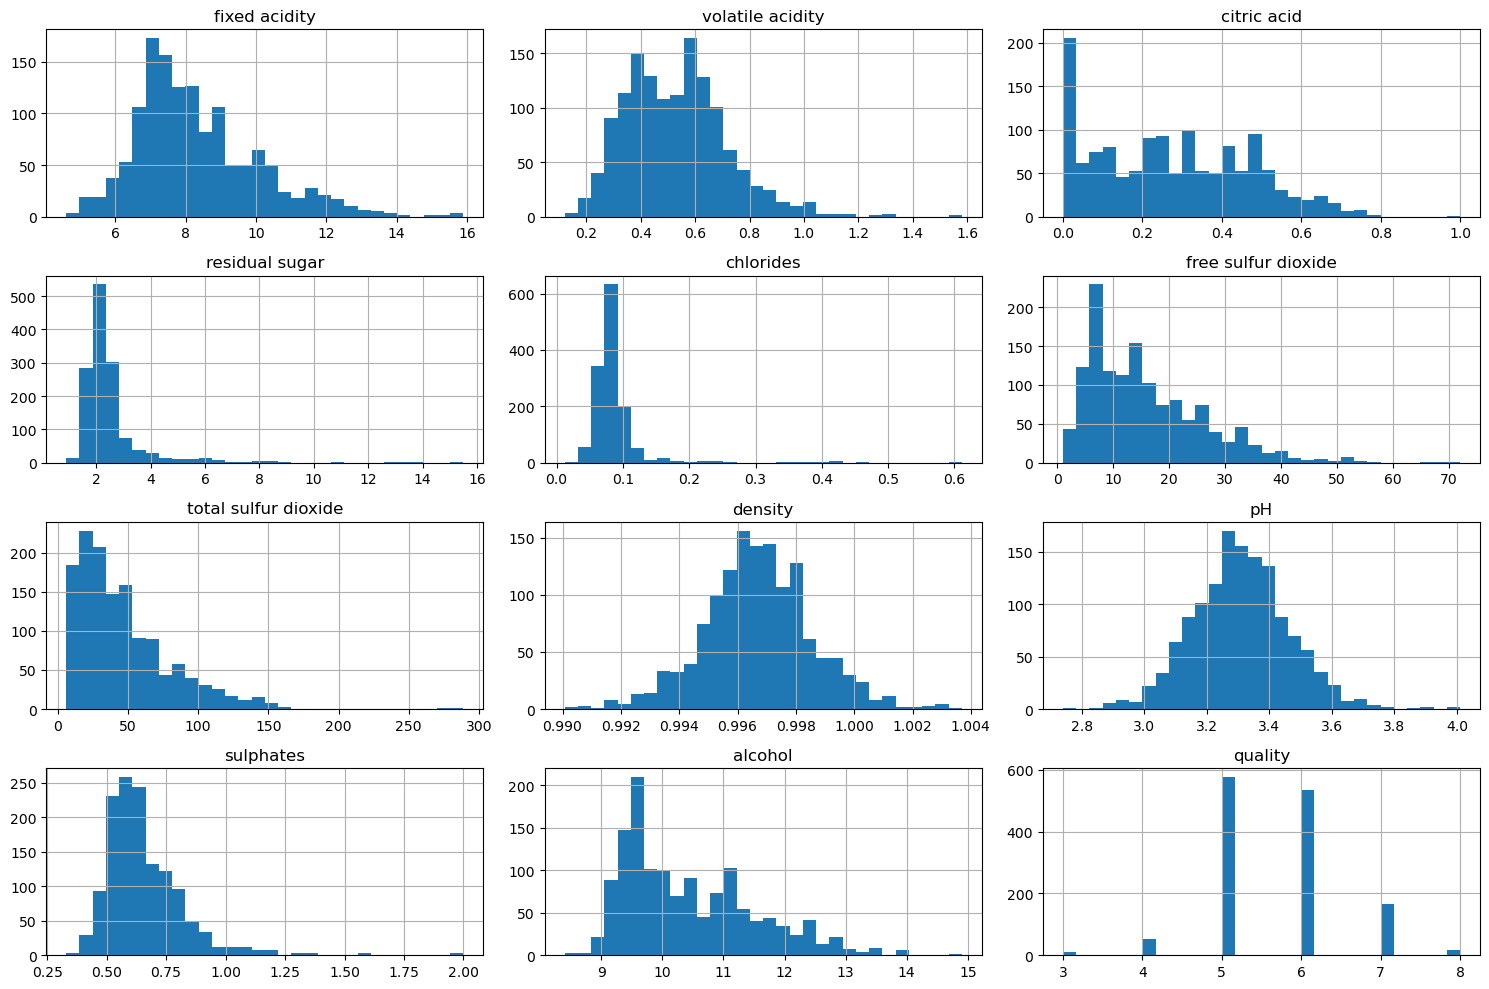

Number of rows after duplicate removal: 1359


In [3]:
# Drop duplicated rows
df.drop_duplicates(inplace=True)

display(df.describe().round(2))

# Plot histograms for all variables
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

print(f'Number of rows after duplicate removal: {df.shape[0]}')

Most independent variables show (right-skewed) normal distributions, except for citric acid, which shows a peculiar looking distribution or (free/total) sulfur dioxide, which show exponential distributions. The dependent variable (quality) is normally distributed, but notice how there are only 6 unique values and the values are discrete integers. All variables have values in different ranges, so we will normalize all independent variables to detect outliers:

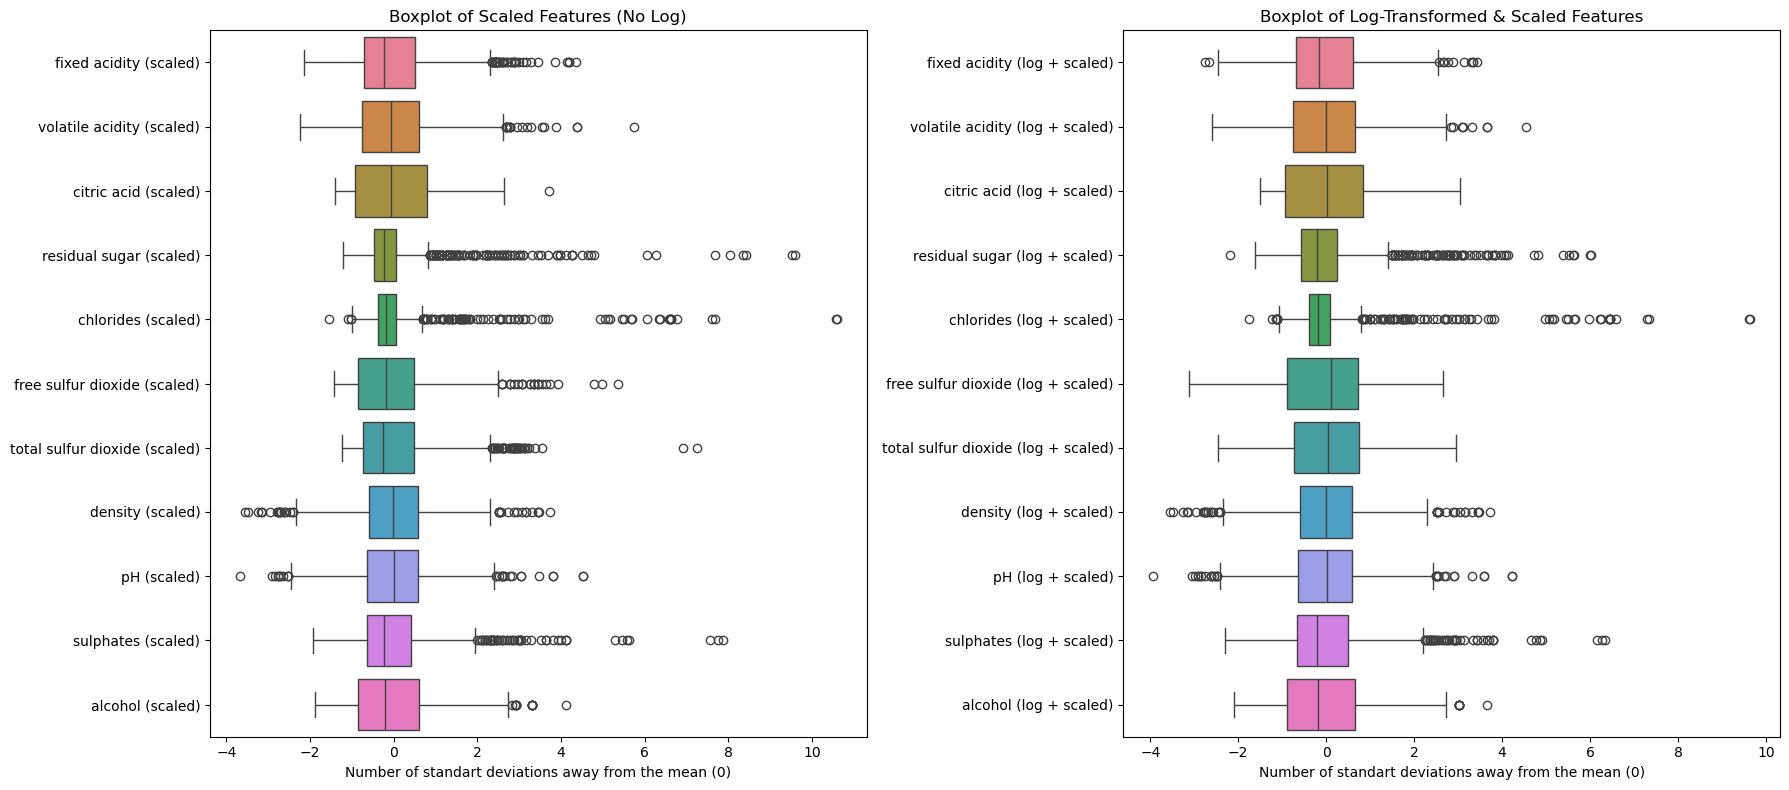

In [4]:
# Select independent and dependent variables
X = df.iloc[:, :-1]  # First 11 columns (independent variables)
y = df.iloc[:, -1]   # Last column (dependent variable)

# Standard Scaling (without log transformation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame for visualization
X_scaled_df = pd.DataFrame(X_scaled, columns=[f"{col} (scaled)" for col in X.columns])

# Log Transform and then Scale
X_log_transformed = np.log1p(X)  # Apply log transformation
X_log_scaled = scaler.fit_transform(X_log_transformed)  # Apply scaling

# Convert to DataFrame for visualization
X_log_scaled_df = pd.DataFrame(X_log_scaled, columns=[f"{col} (log + scaled)" for col in X.columns])

# Create subplots to show both boxplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns

# Plot the original scaled boxplot
sns.boxplot(data=X_scaled_df, orient="h", ax=axes[0])
axes[0].set_title("Boxplot of Scaled Features (No Log)")
axes[0].set_xlabel("Number of standart deviations away from the mean (0)")

# Plot the log-transformed and scaled boxplot
sns.boxplot(data=X_log_scaled_df, orient="h", ax=axes[1])
axes[1].set_title("Boxplot of Log-Transformed & Scaled Features")
axes[1].set_xlabel("Number of standart deviations away from the mean (0)")

# Display the plots
plt.tight_layout()
plt.show()


On the left hand side plot, the features were scaled, where the mean is 0 and the numbers on the x-axis denote standart deviations. We can see a huge number of points outside of whiskers, especially to the right of the boxes. There is even one value more than 10 SDs away from the mean. We tried to address this issue first by applying a log(x + 1) transformation and then scaling, the resulting boxplots are displayed on the right hand side of the above output. The log transformation was very helpful in removing outliers for features with exponential distributions (i.e. free & total sulfur dioxide), but not for others. We decided that log transformations, therefore, is not worth it as it would decrease the interpretability, while not improving much in return. 

Unfortunatelly, we do not have data to suggest that the outlier values are experimental or statistical errors, so we chose not to remove ANY values and proceed as usual. Let's have a look at all feature vs quality plots:
### Exploratory data analysis

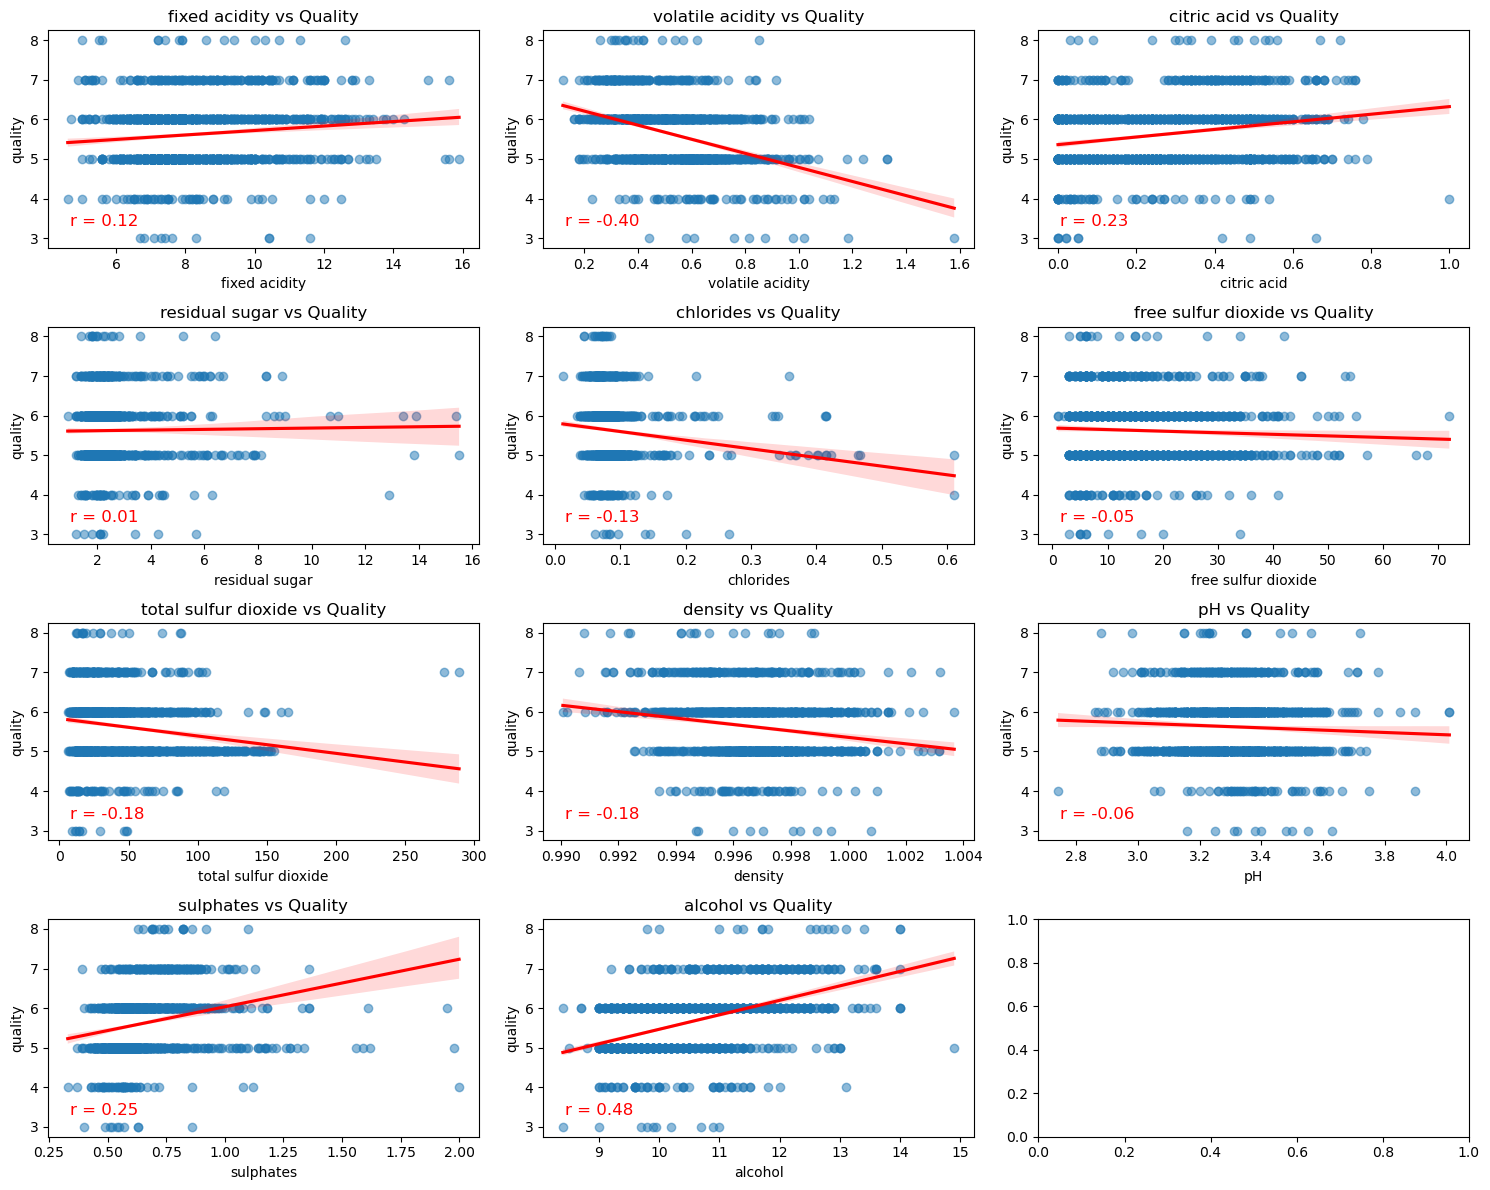

In [5]:
# Create subplots (4 rows, 3 columns) - Adjust based on number of variables
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # Flatten to easily iterate over subplots

# Loop through all independent variables
for i, col in enumerate(X.columns):
    # Scatter plot with regression line
    sns.regplot(x=df[col], y=df['quality'], ax=axes[i], scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
    
    # Compute Pearson correlation coefficient
    r_value, _ = pearsonr(df[col], df['quality'])
    
    # Add r-value as text
    axes[i].text(0.05, 0.1, f"r = {r_value:.2f}", transform=axes[i].transAxes, fontsize=12, color='red')

    # Set title
    axes[i].set_title(f'{col} vs Quality')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


As we can see from the plots and their corresponding r values, most features are not strongly correlated with red wine quality. However, alcohol appears to be most important factor in determining the quality rating of a given wine (r= 0.48), while volatile acid is inversely correlated with quality (r= -0.40). Now let's have a look at feature vs. feature scatterplots to look for multicolinearity:

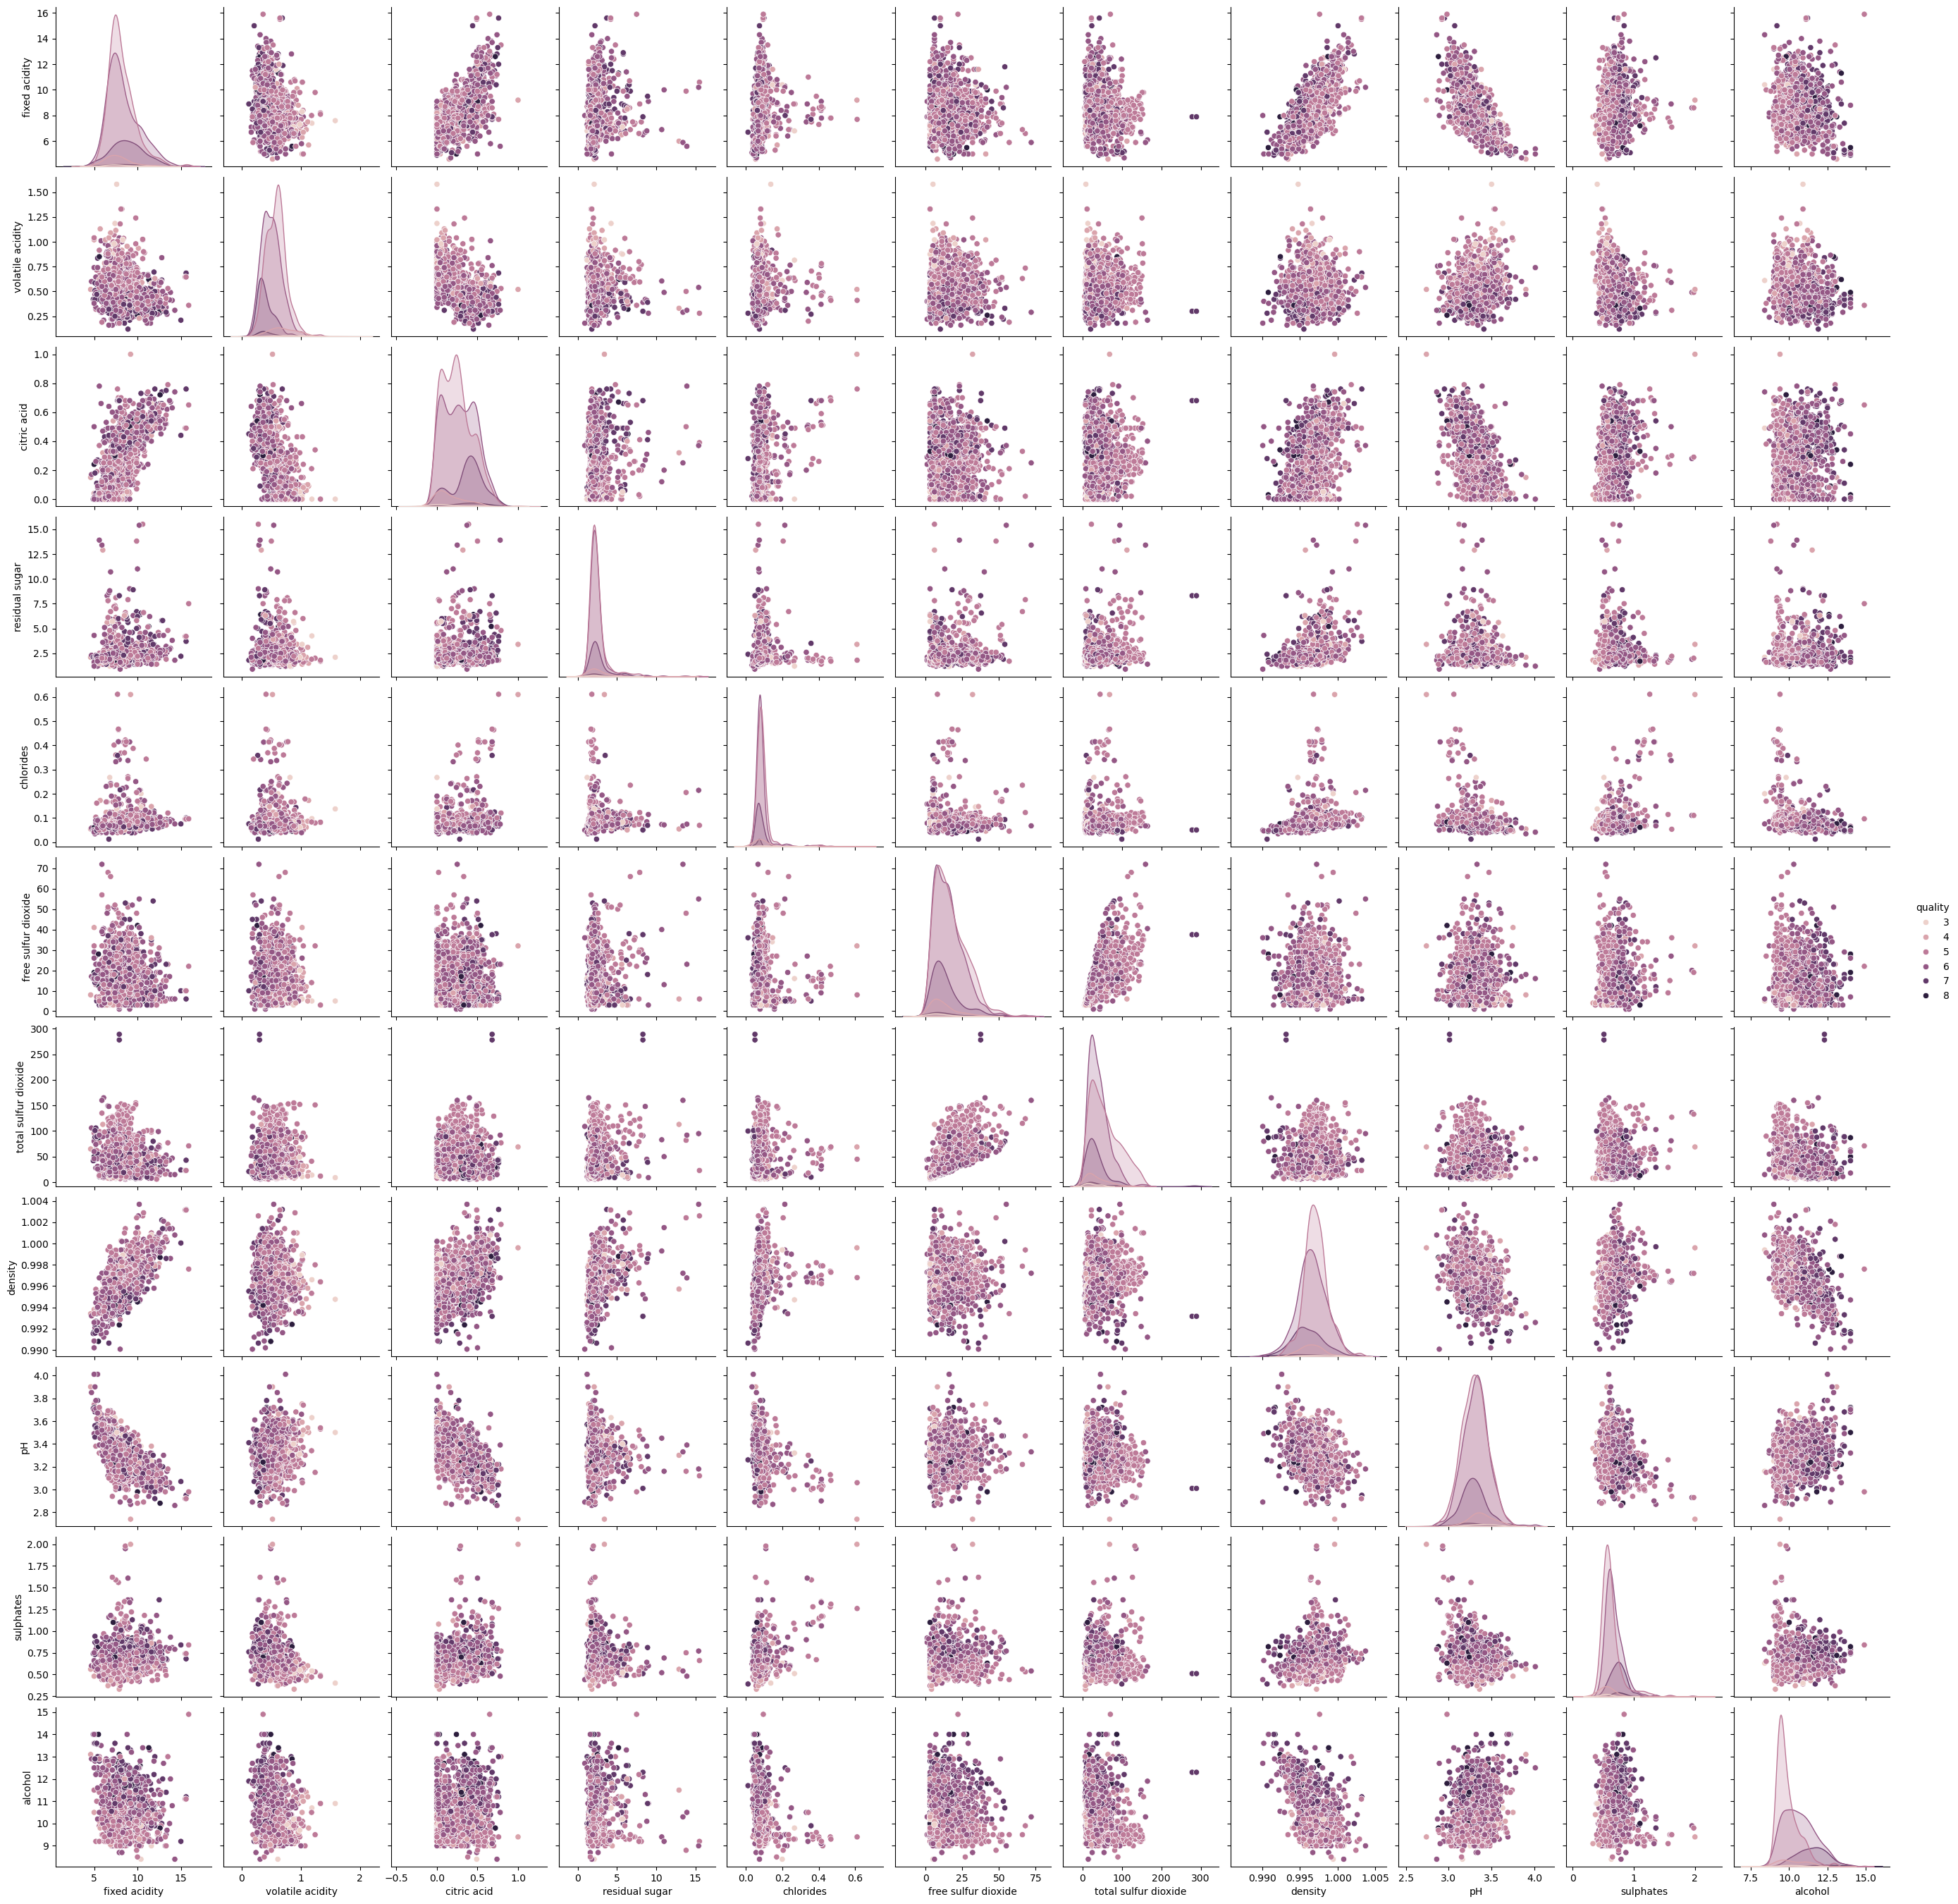

In [6]:
# Pairplots
sns.pairplot(df, hue="quality")
plt.show()

There seems to be quite a few correlations between features, e.g. fixed acidity vs pH (negative exponential relationship), alcohol-density (negative linear) fixed acidity-density (positive linear) and many more. These will have to be adressed as linear regression models assume that features have no multicolinearity. let's have a look at a correlation matrix, which summarizes the two previous plots:

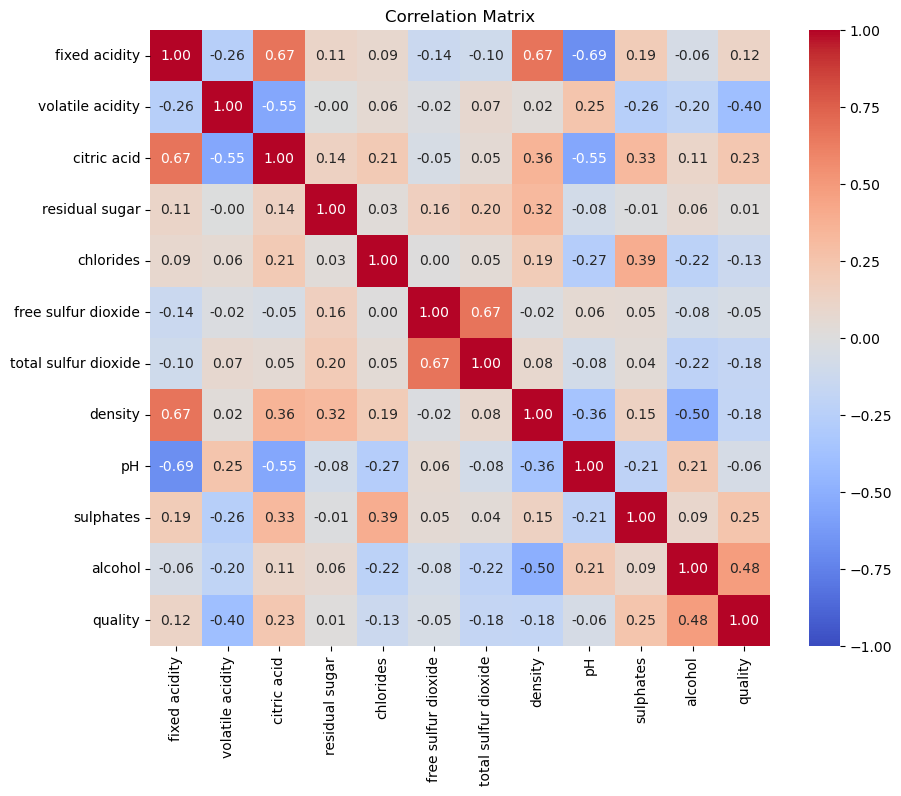

In [7]:
# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1,vmax=1)
plt.title("Correlation Matrix")
plt.show()

As we can see, there are quite a few interactions (correlations): fixed acidity vs. (citric acid, density, pH), volatile acidity vs. citric acid, citric acid vs pH, free sulfur dioxide vs. total sulfur dioxide and density vs. alcohol. These will have to be adressed. Another metric to assess the level of multicolinearity is variance inflation factor (VIF). VIF of 5< indicates possible interaction, whereas 10< indicates multicolinearity.

In [8]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

feature          VIF
0          fixed acidity    75.023032
1       volatile acidity    16.460387
2            citric acid     9.188892
3         residual sugar     4.915733
4              chlorides     6.349793
5    free sulfur dioxide     6.432241
6   total sulfur dioxide     6.543918
7                density  1500.387873
8                     pH  1095.732046
9              sulphates    21.946341
10               alcohol   123.097449

As we can see there are 6 features with VIF>10 indicating high degree of multicolinearity, to obtain a good linear model we will have to eliminate some (or all) of these features. Now, let's move to regression modelling:

### Linear regression model
First, we split the data 80/20 for training/testing, add a constant for the intercept term and then fit a linear regression model my minimizing the squared residuals. We initially train the model without removing any features just to have a reference to improve upon:

In [9]:
# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y) # stratify

# Convert back to DataFrame with original column names (keep indices aligned)
X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)  # Assign index of y_train
X_test = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)  # Assign index of y_test

# Add a constant for the intercept term
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Convert y_train and y_test to DataFrames (ensuring index alignment)
y_train = pd.DataFrame(y_train, columns=["quality"])
y_test = pd.DataFrame(y_test, columns=["quality"])

# Fit the linear model using only the training data
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     54.95
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           2.81e-96
Time:                        17:32:30   Log-Likelihood:                -1089.9
No. Observations:                1087   AIC:                             2204.
Df Residuals:                    1075   BIC:                             2264.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6259 

As we can see from the P>|t| column, features that have p values higher than 0.05 (significance level = 5%) can be removed, since their coefficients are not significantly different from 0. So, we can easily remove 'fixed acidity', 'citric acid', 'residual sugar', 'density' features. Let's check for multicolinearity after the removal of some of the features:

In [10]:
# Drop insignificant features (p >0.05)
X_refined = X_train.drop(columns= ['fixed acidity', 'citric acid', 'residual sugar', 'density'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_refined.columns
vif_data["VIF"] = [variance_inflation_factor(X_refined.values, i) for i in range(X_refined.shape[1])]

vif_data

feature       VIF
0                 const  1.001367
1      volatile acidity  1.263431
2             chlorides  1.310207
3   free sulfur dioxide  1.912549
4  total sulfur dioxide  1.980313
5                    pH  1.290811
6             sulphates  1.299699
7               alcohol  1.229092

All values of VIF are now below 5, which means that multicolinearity is not a problem anymore! Now, let's refit the model:

In [11]:
# Refit the model
refined_model = sm.OLS(y_train, X_refined).fit()

print(refined_model.summary())



                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     86.27
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           1.16e-99
Time:                        17:32:30   Log-Likelihood:                -1090.8
No. Observations:                1087   AIC:                             2198.
Df Residuals:                    1079   BIC:                             2238.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6260 

free sulfur dioxide now appears to be insignificant, so we will drop tis feature and refit the model:

In [12]:
# Drop insignificant features (p >0.05)
X_refined = X_train.drop(columns= ['fixed acidity', 'citric acid', 'residual sugar', 'density', 'free sulfur dioxide'])

# Refit the model
refined_model = sm.OLS(y_train, X_refined).fit()

print(refined_model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     99.86
Date:                Thu, 06 Mar 2025   Prob (F-statistic):          5.94e-100
Time:                        17:32:30   Log-Likelihood:                -1092.5
No. Observations:                1087   AIC:                             2199.
Df Residuals:                    1080   BIC:                             2234.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6262 

The variables that explain the wine quality can be split into positive (those that increase wine rating with increasing concentration) and negative (those that decrease wine rating with decreasing concentration). The positive features in decreasing order of significance are: alcohol, sulphates,while the negative  features are: volatile acidity, total sulfur dioxide, chlorides, pH.

### Summary
Now, we can see that all remaining features have p-values less that significance level of 5%, meaning that all of then are significant. The values that have the highest absolute coeffients or t values contribute to quality rating the most. 

Alcohol appears to explain the most in term of subjective quality rating. The coefficient of 0.31 indicates that increase of alcohol content by one standart deviation increases subjective quality rating by 0.31. This confirms our hypothesis nr. 1 \
Density was one of the removed features, so we can confirm that it has no direct effect on subjective rating of red wine. This confirms our hypothesis nr. 2 \
Volatile acidity has a negative effect on quality- increase of 1 SD of volatile acidity dereases quality rating by 0.17. This makes sense, because volatile acids smell sour, which is usually associated with spoiled or rotten foods. This confirms our hypothesis nr. 3

Other coefficients can be similarly interpreted.

### Hypotheses
1) Red wines with higher alcohol content will have a higher rating
2) Density will not have a direct significant effect on subjective rating of red wines
3) Volatile acidity will be inversely correlated to subjective rating of red wines

### Model evaluation
Now let's evaluate our model by checking the assumption of linear regression:
1) Residuals are normally distributed

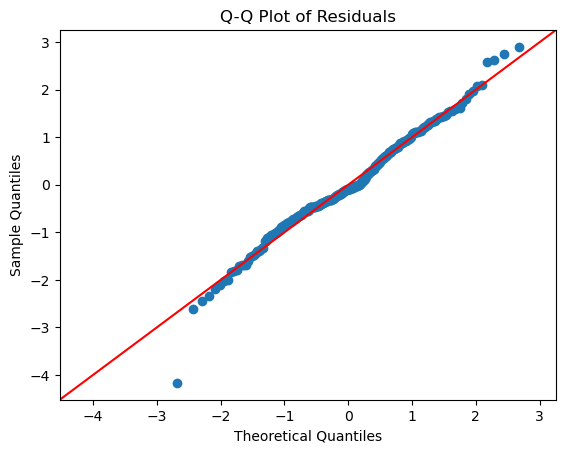

In [13]:
# Make prediction on the test set
y_pred = model.predict(X_test) # should return Pandas series

# Compute residuals
residuals = y_test["quality"] - y_pred

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

The Q-Q plot above shows that all residuals, except for the ones far away from the mean, are normally distributed as displayed by perfect alignment to the 45 degree line. So, the first assumption is satisfied.
2) Second assumption of linear regression is that the residuals are homoscedastic (the variance is constant)

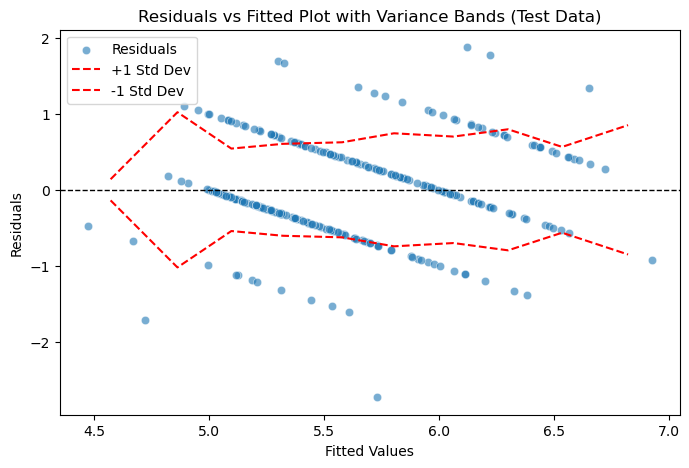

In [14]:
# Compute residuals using TEST data
y_pred_test = model.predict(X_test)  # Get predictions for test data
residuals = y_test.squeeze() - y_pred_test  # Compute residuals
fitted_values = y_pred_test  # Use test predictions as fitted values

# Create DataFrame
df = pd.DataFrame({'Fitted Values': fitted_values, 'Residuals': residuals})

# Compute mean and standard deviation of residuals in bins
df["Residual_Bin"] = pd.cut(df["Fitted Values"], bins=10)  # Divide fitted values into 10 bins
std_by_bin = df.groupby("Residual_Bin", observed=True)["Residuals"].std()

# Compute bin centers
bin_centers = df.groupby("Residual_Bin", observed=True)["Fitted Values"].mean()

# Scatter plot of residuals
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Fitted Values"], y=df["Residuals"], alpha=0.6, label="Residuals")

# Add ±1 standard deviation bands
plt.plot(bin_centers, std_by_bin, color="red", label="+1 Std Dev", linestyle='dashed')
plt.plot(bin_centers, -std_by_bin, color="red", label="-1 Std Dev", linestyle='dashed')

plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.title("Residuals vs Fitted Plot with Variance Bands (Test Data)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()


The plot above shows residuals vs. fitted plot with variance shown. As we can see, the variance bands are mostly parallel (except for extremes), showing that the residuals are heterocedastic. So, the second assumption is  at least partially unsatisfied.

The reason why the predicted values lie in a this short interval is because, there were very few values of 3,8 (extremes), so the model only predicts values in the range:

In [15]:
print(f"The model range is: {df["Fitted Values"].min(), df["Fitted Values"].max()}")

The model range is: (4.473961592202919, 6.92596276776169)


3) The third assumption of linear regression is that the features are independent (no multicolinearity)

In [16]:
# Drop the same features from X_test as in X_train
features_to_drop = ['fixed acidity', 'citric acid', 'residual sugar', 'density']
X_test_cleaned = X_test.drop(columns=features_to_drop, errors='ignore')

# Remove the constant column (if added before)
X_test_cleaned = X_test_cleaned.drop(columns=["const"], errors="ignore")

# Compute VIF for each independent variable in the test set
vif_data = pd.DataFrame()
vif_data["Feature"] = X_test_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(X_test_cleaned.values, i) for i in range(X_test_cleaned.shape[1])]

# Display results
vif_data


Feature       VIF
0      volatile acidity  1.196695
1             chlorides  1.642966
2   free sulfur dioxide  1.770280
3  total sulfur dioxide  1.871086
4                    pH  1.246331
5             sulphates  1.659897
6               alcohol  1.294587

Doing another VIF analysis on test data, we can see that there is no multicolinearity (VIFs <5). So, the third assumption is satisfied.
Finally, let's see what is the R squared value on the test data:

In [17]:
# Compute R² for test data
r2_test = r2_score(y_test, y_pred_test)
print(f"R² on test data: {r2_test:.4f}")


R² on test data: 0.3657


This number indicates that around 37% of the variance in the dependent variable is explained by the model, meaning that the model fits the data poorly and could be improved.

### Conclusion and improvements
The variables that explain the wine quality can be split into positive (those that increase wine rating with increasing concentration) and negative (those that decrease wine rating with decreasing concentration). The positive features in decreasing order of significance are: alcohol, sulphates, free sulfur dioxide, while the negative features are: volatile acidity, total sulfur dioxide, chlorides, pH. So, theoretically, to maximize the perceived wine quality one must maximize the positive features and minimize the negative features.

The linear model explains only 37% of variance in the dependent variable of the test data. There could be a few reasons for this:
- A lot of features have a right-skewed distributions with a lot of outliers, that we were unable to normalize.
- Linear regression assumes features and dependent variable to be continuous, whereas the quality term is a discrete integer. This causes the increase in residuals as the predicted value is often not an integer.
- Linear model could not be the most accurate fit for the problem.

How to improve the model?
1) Implement transformations of features that would remove most 'outliers'. For example, log(x+1) transformation for free/total sulfur dioxide.
2) consider rounding the predicted quality value to the closest integer to minimize the difference between the predicted and actual values.
3) Due to the dependent variable only having 6 values, it is actually an ordinal variable (ordered categorical) and not continuous as assumed by linear regression. Therefore, a better regression to model this system would be ordinal regression model.
